In [1]:
# Importing the needed utilities for NN
import tensorflow as tf
from tensorflow.keras import Model, Input, models
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization, Dropout, Flatten, Dense, InputLayer, Concatenate, Add, SeparableConv2D, Layer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import TruncatedNormal

from sklearn.model_selection import RepeatedKFold # KFold

import matplotlib.pyplot as plt # Plotting

# Data Wrangling
import numpy as np
import pandas as pd 

# Data Preprocessing
- It might be misleading to create data for the missing signal values, hence they are imputed with zeros.
- There are 6000 rows and 10 columns in each csv file within train and test folders. In order to extract features from all of these .csv files, I have stored the measures of central tendency for each .csv file. 
- Two type of data:
    - Raw: Mean, std, etc.
    - Rolling: Got the measures of central tendency for the mean and std of the rolling data.

##### Data is imported from: <a href="https://www.kaggle.com/damoonshahhosseini/volcano-pca">reduced-data</a>
##### Neural Networks saved here: <a href="https://www.kaggle.com/damoonshahhosseini/volcanonn">volcano-nn</a>

In [2]:
train = pd.read_csv('/kaggle/input/predict-volcanic-eruptions-ingv-oe/train.csv') # Training data
sample_submission = pd.read_csv('/kaggle/input/predict-volcanic-eruptions-ingv-oe/sample_submission.csv') 

# Getting the ids
train_ids, test_ids = train['segment_id'], sample_submission['segment_id']

# Value to be predicted
y = train['time_to_eruption']

# Measures of Central Tendency for raw data
X = np.load('/kaggle/input/volcano-pca/train.npy')
X_test = np.load('/kaggle/input/volcano-pca/test.npy')

# Measures of Central Tendency for rolling data
X_rolling = np.load('/kaggle/input/volcano-pca/rolling_train.npy')
X_rolling_test = np.load('/kaggle/input/volcano-pca/rolling_test.npy')

X_concat = np.load('/kaggle/input/volcano-pca/train_concat.npy')
# X_concat_test = np.load('/kaggle/input/volcano-pca/test_concat.npy')


X_aug = np.load('/kaggle/input/volcano-pca/aug_train_concat_2.npy')
y_aug = np.load('/kaggle/input/volcano-pca/y_aug2.npy')

X = X_aug[:, :, :16]
X_rolling = X_aug[:, :, 16:]

# Model's name
MODEL_NAME = 'res32_v3'

In1 = Input(shape=(10, 16, 1))
In2 = Input(shape=(10, 16, 1))
Inm = Input(shape=(10, 32, 1))

# Neural Network Utilities
Some of the fucntion and global entities used in the construction of the Neural Networks.

In [3]:
# The Global weight initializer
WInit = TruncatedNormal(0, 1, 111)

def concat_inputs(Inp1, Inp2): 
    """ Concatenates the raw measures with rolling measures """
    return Concatenate(axis=2)([Inp1, Inp2])
    
def fc(Inp, unit=100, n=3, activation='relu', pred=True, bn=False):
    """ Fully Connected layer used on the flattened data """
    Inp = Flatten()(Inp)
    out = Dense(unit, activation=activation ,kernel_initializer=WInit)(Inp)
    for i in range(0, n-2): 
        out = Dense(unit, activation=activation ,kernel_initializer=WInit)(out)
        if bn: out = BatchNormalization()(out)
        
        
    if not pred: 
        out = Dense(unit, activation=activation ,kernel_initializer=WInit)(out)
        return out 
        
    out = Dense(1, kernel_initializer=TruncatedNormal(10, 1e-1, 11))(out)
        
    return out

def submit_prediction(pred, write=True, file_name="", Return=True):
    """
        Submits prediction and modifies the negative values.
        
        input:
            pred: the predicted values
            write: boolean value indicating if the predictions should be
                written to a csv file.
            file_name: name of the csv file to write
            Return: if the edited predictions should be returned
        
        return:
            returns the edited predictions if asked for (Return==1)
    """
    # Replace the negative values with the mean of the data
    pred = np.where(pred < 0, np.mean(pred), pred)
    
    sample_submission['time_to_eruption'] = pred  # Formatting
    if write: sample_submission.to_csv(f'{file_name}.csv', index=False)  # Write the file to a csv file
    
    if Return: return pred
    

def vertical_kernel(x,y, length): return [(y, x + i) for i in range(length)]
def horizontal_kernel(x,y, length): return [(y + i, x) for i in range(length)]

def module(inp, vertical_kernels, horizontal_kernels, unit=16, std=1e-1, seed=11):
    vertical_convs = [SeparableConv2D(unit, 
                                        kernel_size, 
                                        kernel_initializer=TruncatedNormal(0, std, seed),
                                        bias_initializer=TruncatedNormal(0, std, seed))(inp) for kernel_size in vertical_kernels]
    
    horizontal_convs = [SeparableConv2D(unit, 
                                        kernel_size, 
                                        kernel_initializer=TruncatedNormal(0, std, seed),
                                        bias_initializer=TruncatedNormal(0, std, seed))(inp) for kernel_size in horizontal_kernels]

    vertical_concats = [Concatenate(axis=2)(
        [vertical_convs[i], vertical_convs[len(vertical_convs) - 1 - i]]
    ) for i in range(len(vertical_convs) // 2)]

    horizontal_concats = [Concatenate(axis=1)(
        [horizontal_convs[i], horizontal_convs[len(horizontal_convs) - 1 - i]]
    ) for i in range(len(horizontal_convs) // 2)]
    
    return vertical_concats, horizontal_concats

# Models

In [4]:
def model2(inp):
    vertical_kernels = vertical_kernel(6,10, 8)
    horizontal_kernels = horizontal_kernel(32, 3, 8)

    vert_concat1, hor_concat1 = module(inp, vertical_kernels, horizontal_kernels)

    vert_preds = [fc(layer, unit=100, n=5, activation='relu', pred=True) for layer in vert_concat1]
    hor_preds = [fc(layer, unit=100, n=5, activation='relu', pred=True) for layer in hor_concat1]
    
    vert_preds.extend(hor_preds)
    
    pred = fc(Concatenate()(vert_preds), unit=25, n=3, activation='relu', pred=True)
    
    return pred

In [5]:
def resnet_module(inp, unit=32, stride1=(3,3), stride2=(5,5), stride3=(3,3), mid_activation=None, padding='same', bn=True, std=1e-2, seed=123):
    
    l1 = SeparableConv2D(filters=unit, 
                         kernel_size=stride1, 
                         kernel_initializer=TruncatedNormal(0, std, seed), 
                         padding=padding
                        )(inp)
    
    l2 = SeparableConv2D(filters=unit, 
                         kernel_size=stride2, 
                         kernel_initializer=TruncatedNormal(0, std*1.1, seed),
                         activation=mid_activation,
                         padding='same'
                        )(l1)
    
    l3 = SeparableConv2D(filters=unit, 
                         kernel_size=stride3, 
                         kernel_initializer=TruncatedNormal(0, std*5, seed), 
                         padding=padding
                        )(l2)
    
    la = Add()([l1, l3])
    
    if bn: return BatchNormalization()(la)
    
    return la
    

def mres(inp):
    
    # First three moduls: 10 x 16
    b1 = resnet_module(inp, stride1=(1,3), stride2=(5,5), stride3=(3,1), bn=False, std=1)
    b1 = resnet_module(b1, stride1=(3,1), stride2=(3,3), stride3=(1,3), mid_activation='relu',bn=True, std=1.5)
    b1 = resnet_module(b1, stride1=(3,3), stride2=(3,3), stride3=(3,3), mid_activation='relu',bn=True, std=1)
    
    # Second three moduls: 10 x 16
    b2 = resnet_module(b1, unit=64, stride1=(4,4), stride2=(1,1), stride3=(4,4), mid_activation='relu', bn=False, std=1e-2)
    b2 = resnet_module(b2, unit=64, stride1=(6,1), stride2=(3,3), stride3=(1,6),bn=False, std=1.5e-3)
    b2 = resnet_module(b2, unit=64, stride1=(4,4), stride2=(3,3), stride3=(4,4), mid_activation='relu',bn=False, std=3e-1)
    
     # Second three moduls: 10 x 16
    b3 = resnet_module(b2, unit=128, stride1=(4,4), stride2=(1,1), stride3=(4,4), mid_activation='sigmoid', bn=False, std=1e-2)
    b3 = resnet_module(b3, unit=128, stride1=(6,1), stride2=(3,3), stride3=(1,6),bn=False, std=1.5e-3)
    b3 = resnet_module(b3, unit=128, stride1=(4,4), stride2=(1,1), stride3=(4,4), mid_activation='sigmoid',bn=True, std=3e-1)
    
    b3 = Dropout(0.5)(b3)
    
     # Second three moduls: 10 x 16
    b4 = resnet_module(b3, unit=256, stride1=(3,3), stride2=(1,1), stride3=(3,3), mid_activation='sigmoid', bn=False, std=1e-2)
    b4 = resnet_module(b4, unit=256, stride1=(6,1), stride2=(1,1), stride3=(1,6),bn=False, std=1.5e-3)
    b4 = resnet_module(b4, unit=256, stride1=(2,3), stride2=(1,1), stride3=(2,1), mid_activation='relu',bn=True, std=3e-1)
    
    # Second three moduls: 10 x 16
    b5 = resnet_module(b4, unit=256, stride1=(4,4), stride2=(1,1), stride3=(4,4), mid_activation='sigmoid', bn=True, std=1e-2)
    b5 = resnet_module(b5, unit=256, stride1=(3, 3), stride2=(3,3), stride3=(3,3),bn=False, std=1.5e-3)
    b5 = resnet_module(b5, unit=256, stride1=(4,4), stride2=(3,3), stride3=(4,4), mid_activation='relu',bn=True, std=3e-1)
    
    b5 = Dropout(0.5)(b5)
    
    # Second three moduls: 10 x 16
    b6 = resnet_module(b5, unit=256, stride1=(3,3), stride2=(7,7), stride3=(2,3), mid_activation='relu', bn=True, std=1e-2)
    b6 = resnet_module(b6, unit=256, stride1=(4,1), stride2=(3,3), stride3=(1,4),bn=False, std=1.5e-3)
    b6 = resnet_module(b6, unit=256, stride1=(2,2), stride2=(1,1), stride3=(3,2), mid_activation='relu',bn=True, std=3e-1)
    
    p = fc(b6, unit=100, n=3, activation='relu')
    
    return p

In [6]:
# # Input
# In1 = Input(shape=(10,16,1))

# m1 = model1(In1)
# In = concat_inputs(In1, In2)
# model = Model(inputs=[In1], outputs=[mres(In1)])

In [7]:
# model.count_params() / 1e6

In [8]:
# plot_model(model, show_layer_names=0, show_shapes=1)

In [9]:
model = models.load_model('/kaggle/input/volcanonn/res32_v2')
from tensorflow.keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.0015)

In [10]:
model.optimizer.learning_rate

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>

In [11]:
# model.compile(optimizer=Adam(0.0015), loss='mae')

# hist = model.fit([X, X_rolling], y_aug, epochs= 100, batch_size=32,
#                  callbacks=[
#                      ReduceLROnPlateau(monitor='loss', factor=0.9, patience=10, verbose=1, min_delta=0),
#                      EarlyStopping(monitor='val_loss', min_delta=0, patience=300, verbose=1,
#                                    mode='min', baseline=None, restore_best_weights=True)
#                 ],
    
#                  validation_split=0.3,
#                   verbose=True,
#                   shuffle=True) 

In [12]:
# 0.0015
# (pd.DataFrame(hist.history) / 1e6).plot(y=['loss', 'val_loss'])

# Training with Repeated KFold

In [13]:
def kfold_validation(model, X, y, X_test, n_rep=3, n_fold=5, batch_size=32, epochs=300, verbose=1):
    """
        Runs a repeated KFold on a given model and data
        
        input:
            model: model to traing the data
            X, y, X_test: datasets needed for training and prediction
            n_rep, n_fold: parameters of Repeated KFold
            batch_size, epoch, verbose: info for the training data
        
        return:
            model: trained model
            preds: predictions at each fold
            avg_preds: average of all predictions
    """
    history, index = {}, 0  # Keep track of the loss and val_loss (history object)
    prediction = np.zeros((X_test.shape[0])) # For every single prediction
    preds = np.empty((n_rep * n_fold, X_test.shape[0])) # Saving all the predictions
    
    kf = RepeatedKFold(n_splits=n_fold, n_repeats=n_rep, random_state=288490)
    
    for train_indices, val_indices in kf.split(X, y):
    
        print(f'{index + 1}th fold, Validation Indices: ', val_indices[:5])

        # Data divided into Train and Validation splits
        X_train, X_val = X[train_indices], X[val_indices]
        X_rolling_train, X_rolling_val = X_rolling[train_indices], X_rolling[val_indices]
        y_train, y_val = y[train_indices], y[val_indices]

        # Fitting
        history[index] = model.fit(
            x=[X_train, X_rolling_train], 
            y=y_train, 
            epochs=epochs,
            batch_size=batch_size,
            validation_data=([X_val, X_rolling_val], y_val),
            verbose=verbose,
            callbacks=[ 
                ReduceLROnPlateau(factor=0.96, patience=10, verbose=True, monitor='val_loss', min_lr=1e-45, min_delta=1e-4),
                EarlyStopping(
                    monitor='val_loss', 
                    patience=25, 
                    restore_best_weights=True, 
                    min_delta=1e4, 
                    verbose=True
                )
            ]
        )
        
        
        model_prediction = model.predict([X_test, X_rolling_test], 
                                         batch_size=batch_size, 
                                         verbose=False).reshape(X_test.shape[0])
        
        model_prediction = submit_prediction(model_prediction, 
                                             write=True, 
                                             file_name=f"sub{index}", 
                                             Return=True)
        
        # Saving the predictions for each fold
        preds[index] = model_prediction
        index += 1
        
        # Starting different fold or end of folding
        print('#----------------#----------------#----------------#----------------#----------------#')
        
    # Averaging the predictions
    p = pd.DataFrame(preds)
    p = p.sum() / (n_fold * n_rep)
        
    avg_pred = submit_prediction(p, 
                      write=True, 
                      file_name=f"S_avg", 
                      Return=True)
    
    return model, preds, avg_pred, history

In [14]:
model, preds, avg_pred, history = kfold_validation(model, X, y_aug, X_test, 6, 3, 32, epochs=500, verbose=0)

# Model and its predictions will be saved
np.save('preds_V16.npy', preds)
model.save(f'/kaggle/working/{MODEL_NAME}')

1th fold, Validation Indices:  [2 6 7 8 9]

Epoch 00065: ReduceLROnPlateau reducing learning rate to 0.0014400000125169754.

Epoch 00125: ReduceLROnPlateau reducing learning rate to 0.001382400020956993.

Epoch 00143: ReduceLROnPlateau reducing learning rate to 0.0013271040469408034.

Epoch 00153: ReduceLROnPlateau reducing learning rate to 0.0012740198895335197.

Epoch 00169: ReduceLROnPlateau reducing learning rate to 0.0012230591475963593.

Epoch 00194: ReduceLROnPlateau reducing learning rate to 0.0011741367727518082.

Epoch 00204: ReduceLROnPlateau reducing learning rate to 0.001127171292901039.
Restoring model weights from the end of the best epoch.
Epoch 00209: early stopping
#----------------#----------------#----------------#----------------#----------------#
2th fold, Validation Indices:  [ 1  3  5 14 15]

Epoch 00012: ReduceLROnPlateau reducing learning rate to 0.0010820844769477843.

Epoch 00022: ReduceLROnPlateau reducing learning rate to 0.001038801111280918.
Restoring mo

# Plotting

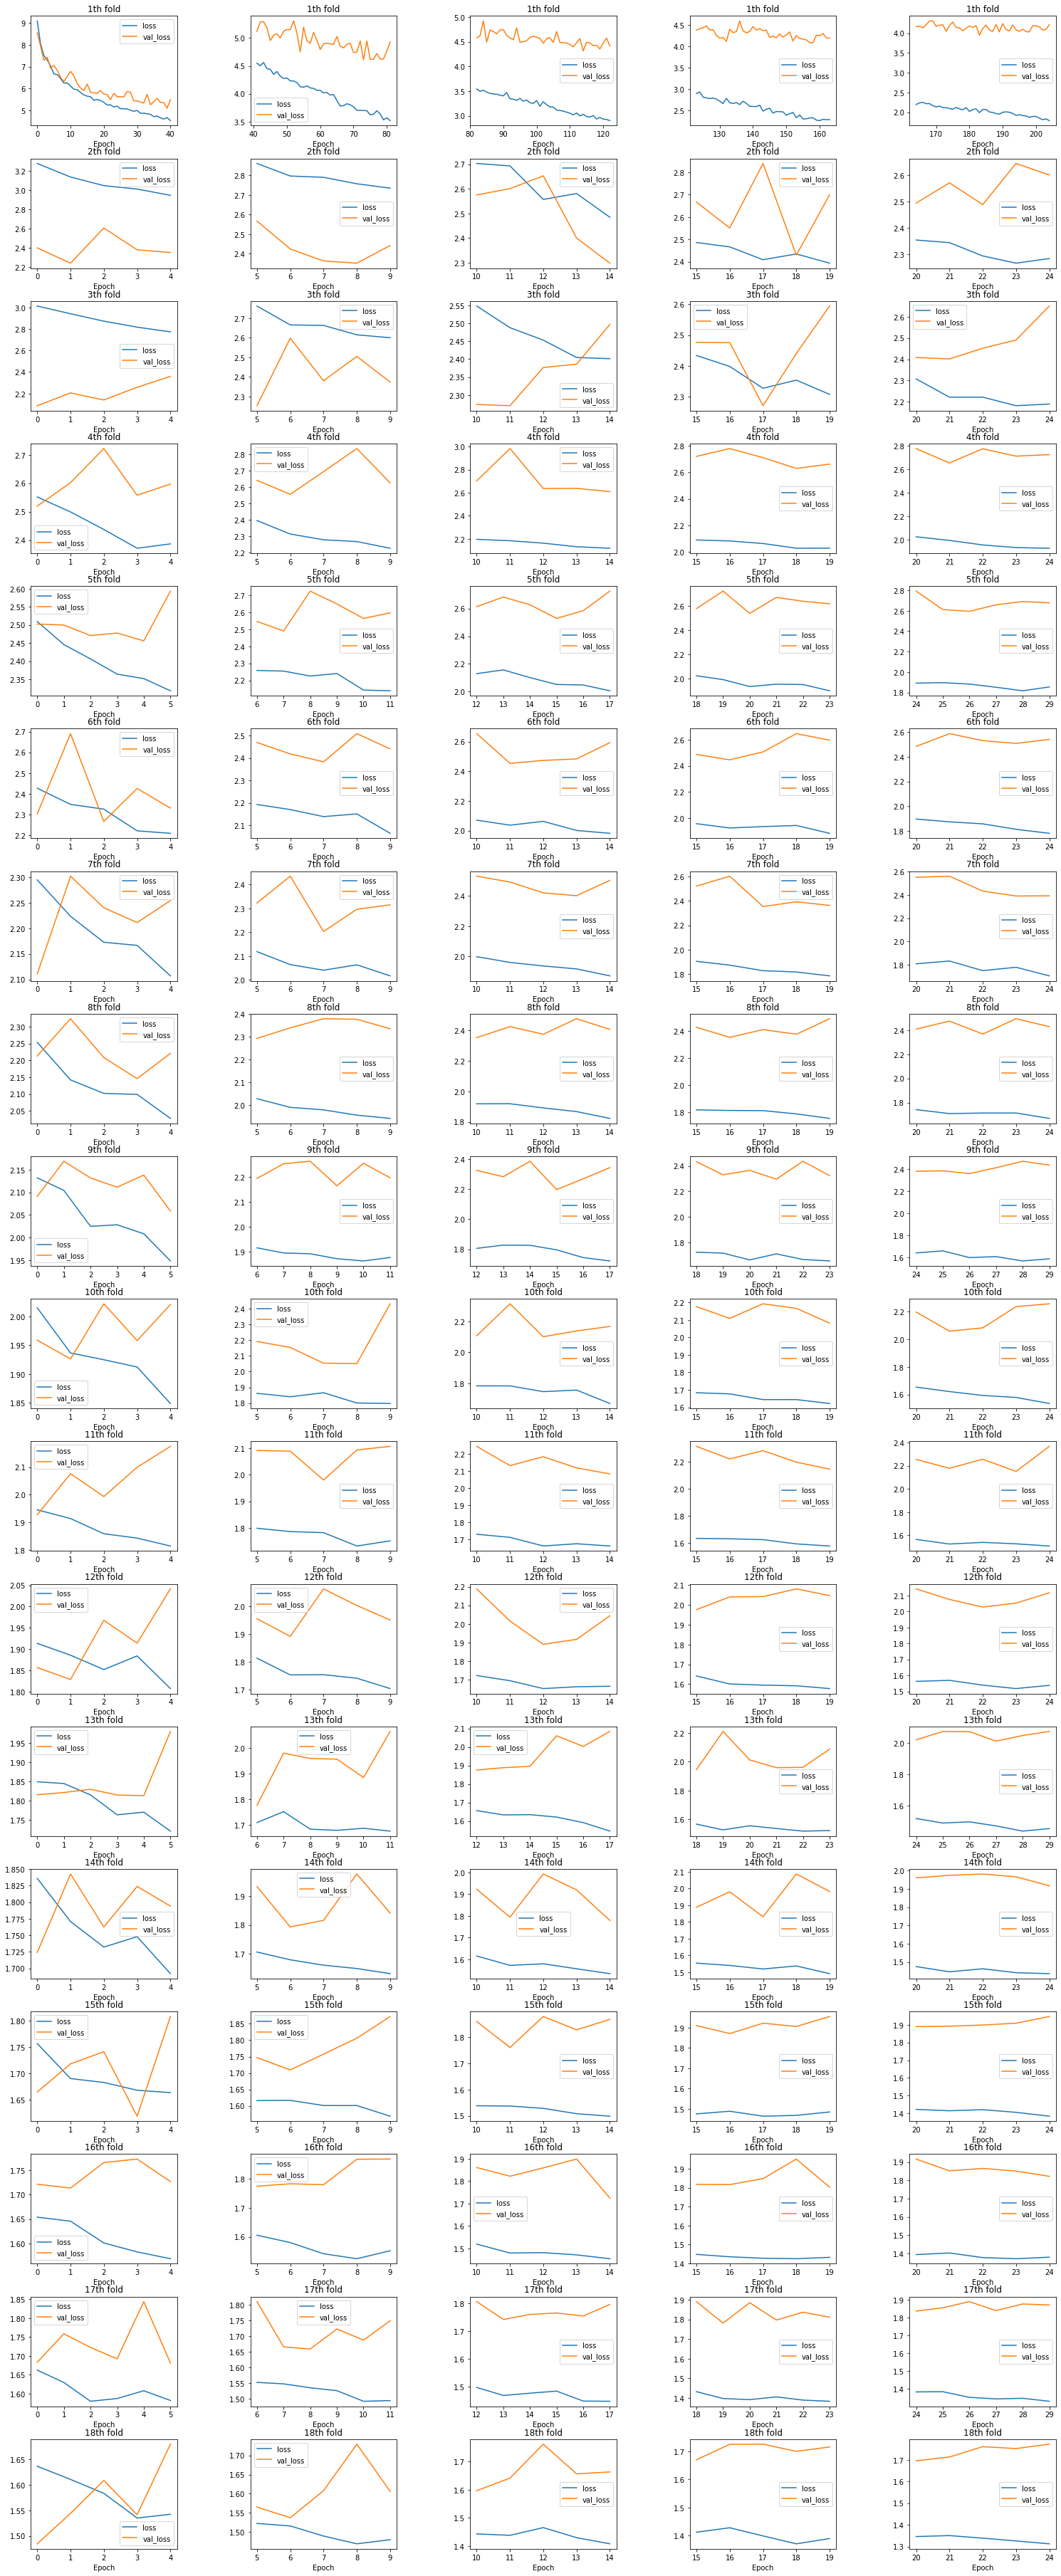

In [15]:
num_cols = 5
fig, axes = plt.subplots(len(history), num_cols, figsize=(200,50))
# fig.legend(["blue", "orange"])
fig.tight_layout()

for i in range(len(history)):
    d = pd.DataFrame(history[i].history) / 1e6
    d['Epoch'] = range(0,d.shape[0])

#     d.iloc[:,:].plot(x="Epoch", y=["loss","val_loss"], ax=axes[i][0])
    for j in range(num_cols):
        d.iloc[d.shape[0]//num_cols*j:d.shape[0]//num_cols*(j+1),:].plot(
            x="Epoch", y=["loss","val_loss"], ax=axes[i][j], title=f'{i+1}th fold')

plt.subplots_adjust(left=0, bottom=None, right=0.1, top=None, wspace=0.5, hspace=0.3)